#  Forecast churn of the telecom operator clients

## Table of contents
1. [Introduction](#intro)
    - [Project description](#project_description)
    - [Data description](#data_description)
    - [The goal of the project](#goal)
2. [Overview](#overview)
    - [Import libraries](#imports)
    - [Study of the general information](#open_file)
    - [Conclusion](#concl_1)
3. [Data preprocessing](#data_preprocessing)
    - [Tables concatenation](#table_concat)
    - [Data types changing](#dt_change)
    - [Conclusion](#concl_2)
4. [Exploratory data analysis (EDA)](#eda)
5. [Machine learning](#ml)
    - [Feature and target preparation](#feature_preparation)
        - [OHE](#ohe)
        - [Feature and target creation](#feature_creation)
    - [Model training](#model_training)
        - [DecisionTreeClassifier](#dt)
        - [RandomForestClassifier](#rd)
        - [LogisticRegression](#logreg)
        - [CatBoostClassifier](#cat)
        - [XGBClassifier](#xgb)
        - [LightGBM](#lgbm)
    - [The best model choosing](#the_best_model)
6. [Overall conclusion](#overall_concl)

## 1. Introduction <a name="intro"></a>

### 1.1. Project description <a name="project_description"></a>
The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

Interconnect mainly provides two types of services:

1. Landline communication. The telephone can be connected to several lines simultaneously.
2. Internet. The network can be set up via a telephone line (DSL, *digital subscriber line*) or through a fiber optic cable.

Some other services the company provides include:

- Internet security: antivirus software (*DeviceProtection*) and a malicious website blocker (*OnlineSecurity*)
- A dedicated technical support line (*TechSupport*)
- Cloud file storage and data backup (*OnlineBackup*)
- TV streaming (*StreamingTV*) and a movie directory (*StreamingMovies*)

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.

### 1.2. Data description <a name="data_description"></a>

The data consists of files obtained from different sources:

- `contract.csv` — contract information
- `personal.csv` — the client's personal data
- `internet.csv` — information about Internet services
- `phone.csv` — information about telephone services

In each file, the column `customerID` contains a unique code assigned to each client.

The contract information is valid as of February 1, 2020.

### 1.3. The goal of the project <a name="goal"></a>

We need to predict whether the client will leave the telecom operator or not.

Primary metric: AUC-ROC.  
Additional metric: Accuracy.

Assessment criteria:

- AUC-ROC < 0.75 — 0 SP
- 0.75 ≤ AUC-ROC < 0.81 — 4 SP
- 0.81 ≤ AUC-ROC < 0.85 — 4.5 SP
- 0.85 ≤ AUC-ROC < 0.87 — 5 SP
- 0.87 ≤ AUC-ROC < 0.88 — 5.5 SP
- AUC-ROC ≥ 0.88 — 6 SP

## 2. Overview <a name="overview"></a>

### 2.1. Import libraries <a name="imports"></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# allow to see all column names and rows, when doing 'head()' method
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### 2.2. Study of the general information <a name="open_file"></a>

*Read the files and save them to the variables*

In [4]:
df_contract = pd.read_csv('contract.csv')
df_personal = pd.read_csv('personal.csv')
df_internet = pd.read_csv('internet.csv')
df_phone = pd.read_csv('phone.csv')

*Print first 5 rows for `df_contract`, `df_personal`, `df_internet`, `df_phone` datasets*

In [5]:
for df in (df_contract, df_personal, df_internet, df_phone):
    df.head() # use head() method

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


*Print last 5 rows for `df_contract`, `df_personal`, `df_internet`, `df_phone` datasets*

In [6]:
for df in (df_contract, df_personal, df_internet, df_phone):
    df.tail() # use tail() method

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6
7042,3186-AJIEK,2014-08-01,No,Two year,Yes,Bank transfer (automatic),105.65,6844.5


,customerID,gender,SeniorCitizen,Partner,Dependents
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No
7042,3186-AJIEK,Male,0,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No
5516,3186-AJIEK,Fiber optic,Yes,No,Yes,Yes,Yes,Yes


,customerID,MultipleLines
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes
6360,3186-AJIEK,No


*Look at the general information of our datasets*

In [7]:
for df in (df_contract, df_personal, df_internet, df_phone):
    df.info() # use info() method
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService

*Use describe() method for more information*

Check the numeric values

In [8]:
for df in (df_contract, df_personal, df_internet, df_phone):
    df.describe() # use describe() method

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,8981-FJGLA,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,8884-FEEWR,No
freq,1,3390


Check the quantitative values

In [9]:
for df in (df_contract, df_personal, df_internet, df_phone):
    df.describe(include='object') # use describe() method with include='object'

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043
unique,7043,77,5,3,2,4,6531
top,8884-FEEWR,2014-02-01,No,Month-to-month,Yes,Electronic check,20.2
freq,1,366,5174,3875,4171,2365,11


,customerID,gender,Partner,Dependents
count,7043,7043,7043,7043
unique,7043,2,2,2
top,8884-FEEWR,Male,No,No
freq,1,3555,3641,4933


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,8981-FJGLA,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,8884-FEEWR,No
freq,1,3390


*Check the duplicates*

In [10]:
for df in (df_contract, df_personal, df_internet, df_phone):
    df.duplicated().sum() # use duplicated() method

0

0

0

0

How do we know whether the client will leave the telecom operator or not?  
We have `EndDate` column in `df_contract` dataset.

*Look at 'EndDate' columns values*

In [11]:
df_contract.EndDate.value_counts() # use value_counts method

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

We have the imbalance of classes. We can fix it later.

### 2.3. Conclusion <a name="concl_1"></a>

We have 4 dataframes with 7043, 7043, 5517, 6361 rows:
- We haven't got missing values. But we'll have them, after concatenation.
- We need to make tables concatenation.
- We need to change object type to: 
    - datetime in `BeginDate`, `EndDate` columns in `df_contract`.
    - float in `TotalCharges` column in `df_contract`. 
    - int in `PaperlessBilling` column in `df_contract`. 
    - int in `Partner`, `Dependents` columns in `df_personal`.
    - int in `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies` columns in `df_internet`.
    - int in `MultipleLines` column in `df_phone`. 
- We have the imbalance of classes.

## 3. Data preprocessing <a name="data_preprocessing"></a>

### 3.1. Tables concatenation <a name="table_concat"></a>

*Use merge method and reduce function for concatenation of the tables*

In [13]:
from functools import reduce

# create the list with our dataframes
dfs = [df_contract, df_personal, df_internet, df_phone]

# merge our dataframes by 'customerID' column
df_concated = reduce(lambda left,right: pd.merge(left,right,on='customerID', how='outer'), dfs)

# drop the 'customerID' column, we don't need it for analysis
df_concated.drop(['customerID'], axis=1, inplace=True)

*Check the values*

In [14]:
df_concated.head()
print()
df_concated.info()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No



<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
MultipleLines       6361 non-null object
dtypes: float64(1), int64(1), object(17)
memory usage: 1.1+ MB


- We'll fill NaN values in:
    - `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, `MultipleLines` columns with 0.
    - `InternetService` column with 'No internet'.
    - `MultipleLines` column with 'No phone'.

### 3.2.  Data types changing <a name="dt_change"></a>

*Replace values from object to datetime in `BeginDate`, `EndDate`*

In [15]:
# replace type with to_datetime func
df_concated['BeginDate'] = pd.to_datetime(df_concated['BeginDate'], format='%Y-%m-%d')
df_concated['EndDate'] = pd.to_datetime(df_concated['EndDate'], format='%Y-%m-%d', errors='coerce')

*Replace values from object to float in `TotalCharges` column*

In [16]:
df_concated['TotalCharges'] = df_concated['TotalCharges'].astype('float') # use astype() method

ValueError: could not convert string to float: 

Ok, we have "string" values in `TotalCharges` column. We should fix them.

*Use regular expressions and str.contains() method to find these values*

In [17]:
df_concated[df_concated['TotalCharges'].str.contains('[^\d.]', regex=True)]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
488,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
753,2020-02-01,NaT,Two year,No,Mailed check,20.25,,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
936,2020-02-01,NaT,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,2020-02-01,NaT,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1340,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
3331,2020-02-01,NaT,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3826,2020-02-01,NaT,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4380,2020-02-01,NaT,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5218,2020-02-01,NaT,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6670,2020-02-01,NaT,Two year,No,Mailed check,73.35,,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


*Probably, this's empty space*

In [18]:
df_concated[df_concated['TotalCharges'].str.contains('[^\d.]', regex=True)]['TotalCharges'][488]

' '

*Replace it with np.nan*

In [19]:
df_concated['TotalCharges'].replace(' ', np.nan, inplace=True)

*Drop NaNs in "TotalCharges" column*

In [20]:
df_concated.dropna(subset=['TotalCharges'], inplace=True) # drop NaN in "TotalCharges" column

*Check the values*

In [21]:
df_concated['TotalCharges'].isna().sum()

0

*Replace values from object to float in `TotalCharges` column again*

In [22]:
df_concated['TotalCharges'] = df_concated['TotalCharges'].astype('float') # use astype() method

*Replace 'Yes' and 'No' (Nan) to '1' and '0' in `PaperlessBilling`, `Partner`, `Dependents`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, `MultipleLines` columns*

In [23]:
# create function to replace 'Yes' and 'No' (NaN) to '1' and '0'
def replace_yes(df, col):
    df[col] = pd.Series(np.where(df[col].values == 'Yes', 1, 0),
          df.index)

In [24]:
# use replace_yes() function for needed columns
replace_yes(df_concated, 'PaperlessBilling')
replace_yes(df_concated, 'Partner')
replace_yes(df_concated, 'Dependents')

for column in ('OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
               'TechSupport', 'StreamingTV', 'StreamingMovies'):
    replace_yes(df_concated, column)

*Replace NaN values in `InternetService` column with 'No internet'*

In [25]:
df_concated['InternetService'].fillna('No internet', inplace=True)

*Replace NaN values in `MultipleLines` column with 'No phone'*

In [26]:
df_concated['MultipleLines'].fillna('No phone', inplace=True)

*Check the values*

In [27]:
df_concated.head() # use head() method
print()
df_concated.info() # use info() method

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,2020-01-01,NaT,Month-to-month,1,Electronic check,29.85,29.85,Female,0,1,0,DSL,0,1,0,0,0,0,No phone
1,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,Male,0,0,0,DSL,1,0,1,0,0,0,No
2,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,Male,0,0,0,DSL,1,1,0,0,0,0,No
3,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,Male,0,0,0,DSL,1,0,1,1,0,0,No phone
4,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,Female,0,0,0,Fiber optic,0,0,0,0,0,0,No



<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 19 columns):
BeginDate           7032 non-null datetime64[ns]
EndDate             1869 non-null datetime64[ns]
Type                7032 non-null object
PaperlessBilling    7032 non-null int64
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
gender              7032 non-null object
SeniorCitizen       7032 non-null int64
Partner             7032 non-null int64
Dependents          7032 non-null int64
InternetService     7032 non-null object
OnlineSecurity      7032 non-null int64
OnlineBackup        7032 non-null int64
DeviceProtection    7032 non-null int64
TechSupport         7032 non-null int64
StreamingTV         7032 non-null int64
StreamingMovies     7032 non-null int64
MultipleLines       7032 non-null object
dtypes: datetime64[ns](2), float64(2), int64(10), object(5)
memory usage: 1.1+ MB


### 3.3. Conclusion <a name="concl_2"></a>

We've merged the tables, converted the data in the needed format and fill NaN values.

## 4. Exploratory data analysis (EDA) <a name="eda"></a>

*Let's look at historams for numerical columns in `df_concated`*

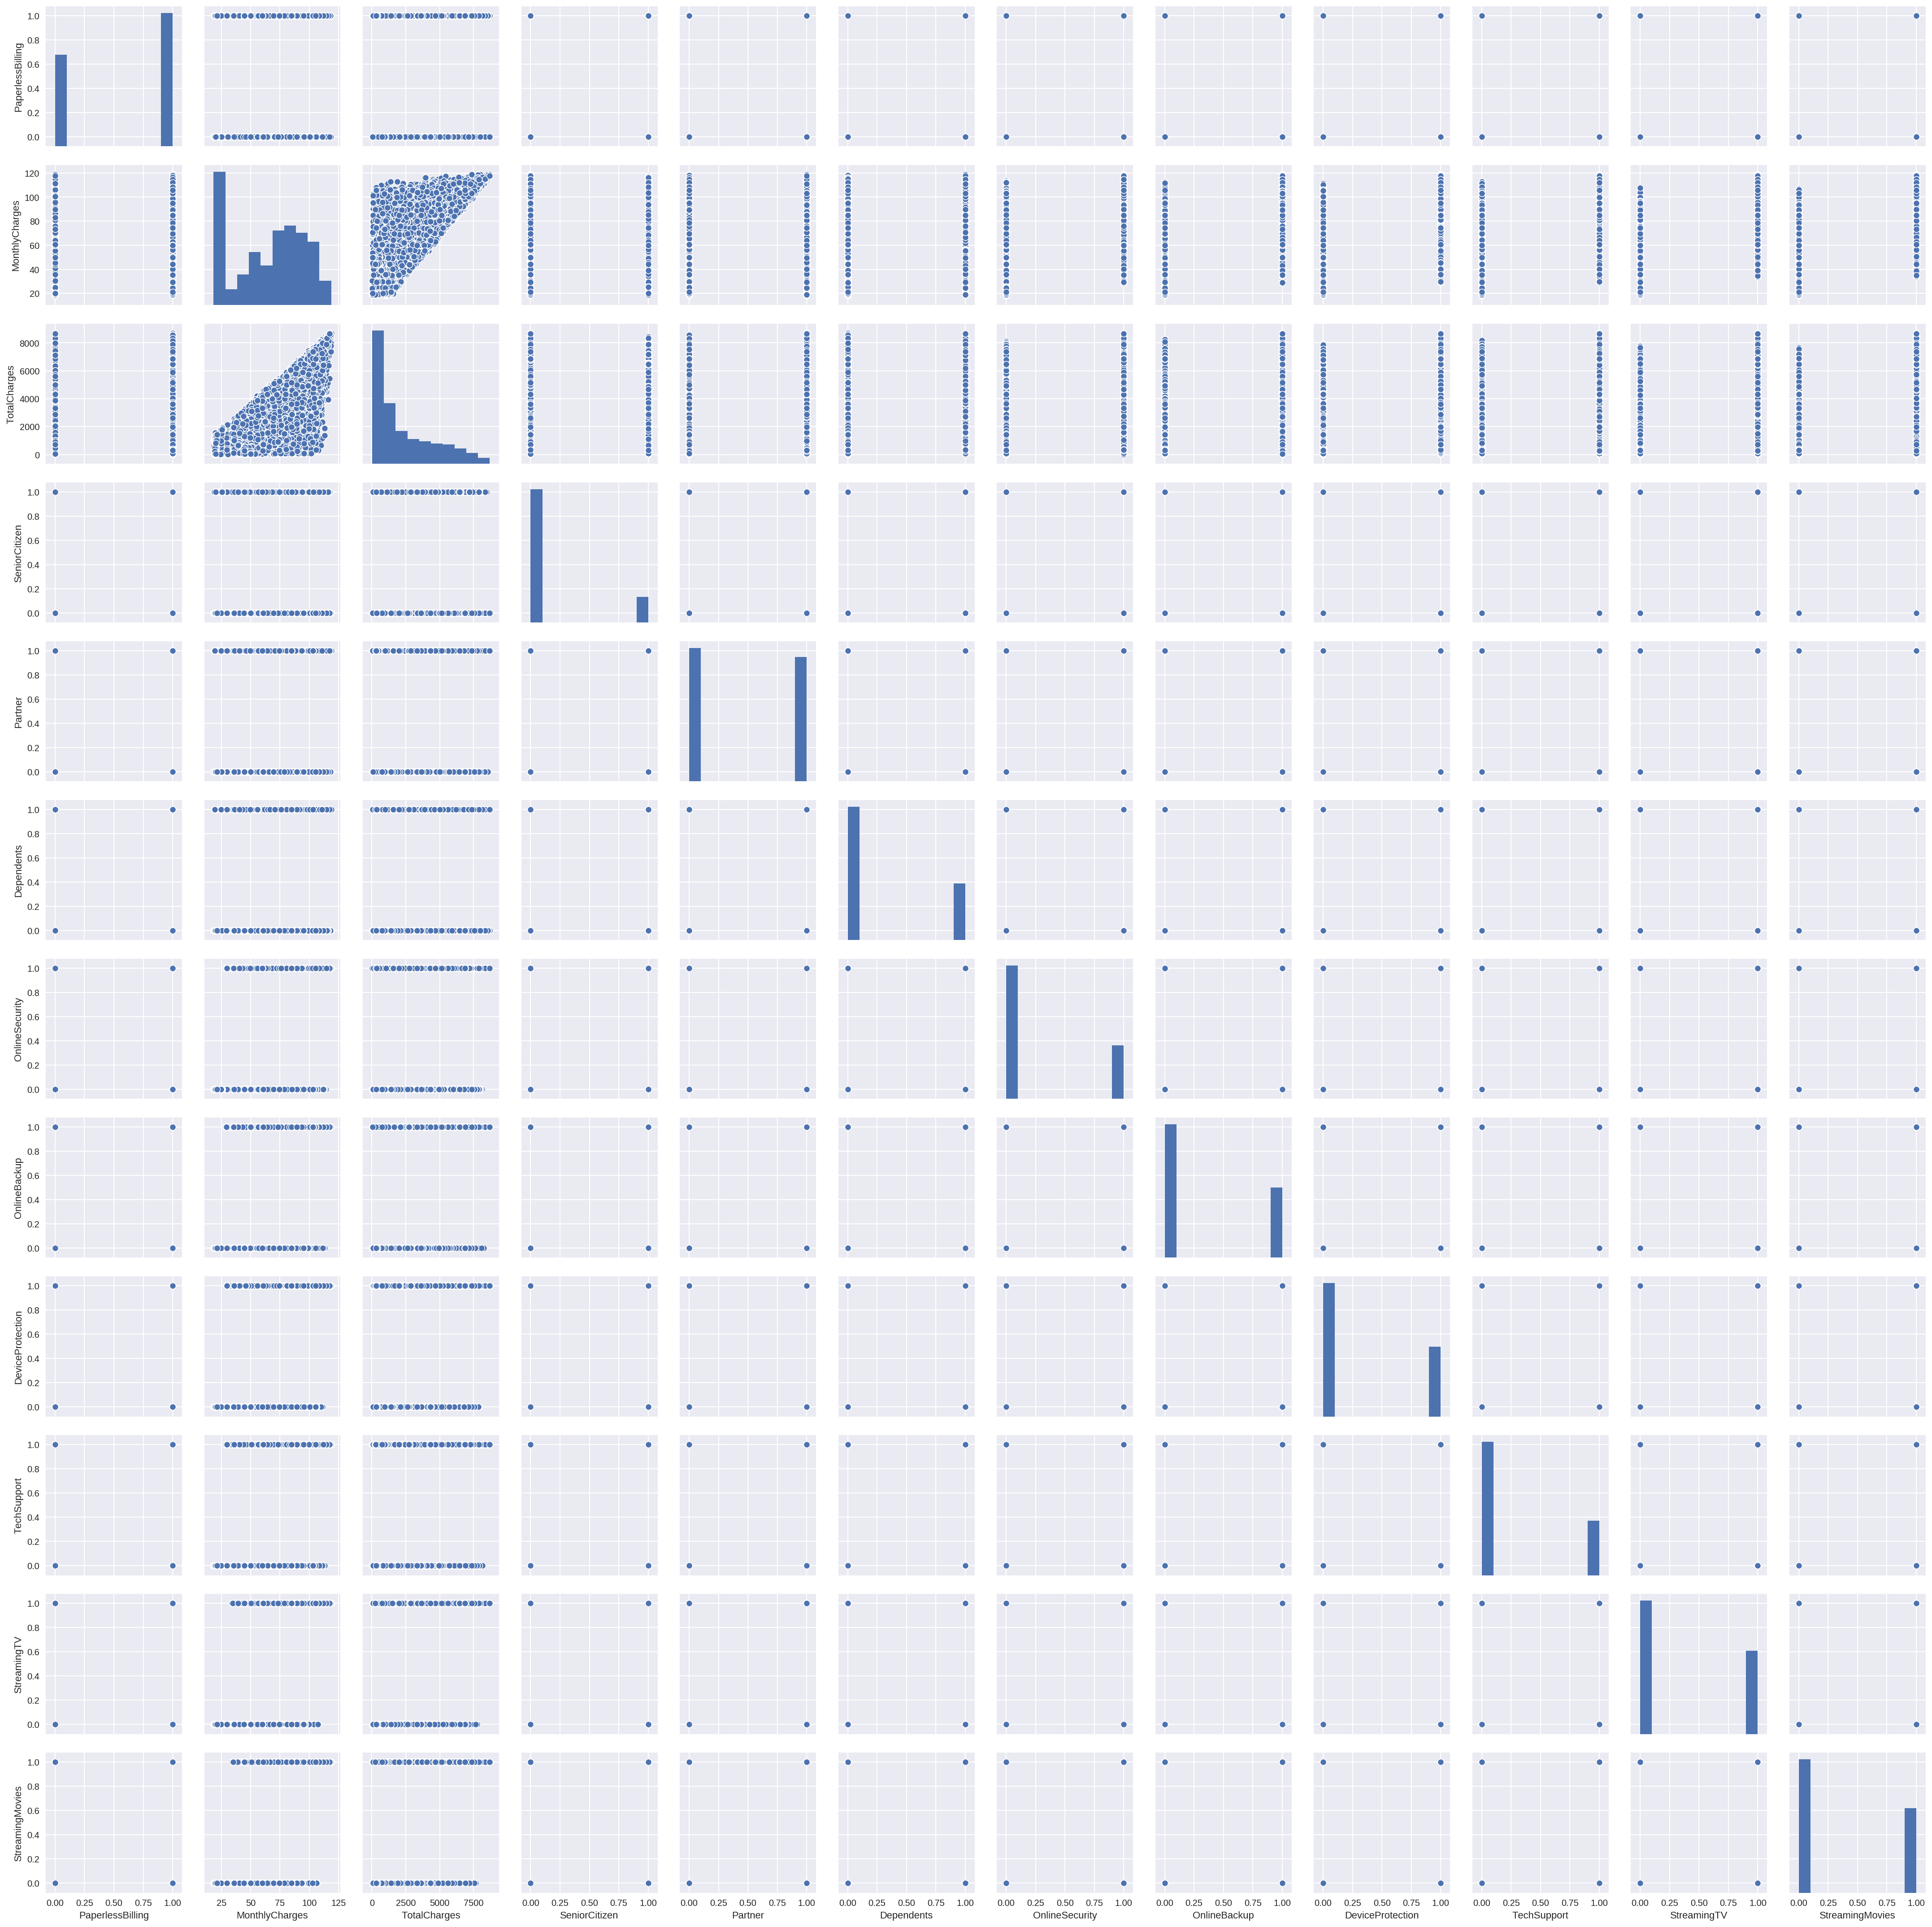

In [28]:
# use pairplot graph from seaborn
sns.pairplot(df_concated);

*Count Pearson correlation coefficient*

In [28]:
df_concated.corr().round(2) # use corr() method

,PaperlessBilling,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
PaperlessBilling,1.00,0.35,0.16,0.16,-0.01,-0.11,-0.00,0.13,0.10,0.04,0.22,0.21
MonthlyCharges,0.35,1.00,0.65,0.22,0.10,-0.11,0.30,0.44,0.48,0.34,0.63,0.63
TotalCharges,0.16,0.65,1.00,0.10,0.32,0.06,0.41,0.51,0.52,0.43,0.52,0.52
SeniorCitizen,0.16,0.22,0.10,1.00,0.02,-0.21,-0.04,0.07,0.06,-0.06,0.11,0.12
Partner,-0.01,0.10,0.32,0.02,1.00,0.45,0.14,0.14,0.15,0.12,0.12,0.12
Dependents,-0.11,-0.11,0.06,-0.21,0.45,1.00,0.08,0.02,0.01,0.06,-0.02,-0.04
OnlineSecurity,-0.00,0.30,0.41,-0.04,0.14,0.08,1.00,0.28,0.27,0.35,0.18,0.19
OnlineBackup,0.13,0.44,0.51,0.07,0.14,0.02,0.28,1.00,0.30,0.29,0.28,0.27
DeviceProtection,0.10,0.48,0.52,0.06,0.15,0.01,0.27,0.30,1.00,0.33,0.39,0.40
TechSupport,0.04,0.34,0.43,-0.06,0.12,0.06,0.35,0.29,0.33,1.00,0.28,0.28


- We have outliers in `MonthlyCharges` column.
- A lot of people are not senior citizens.
- Almost 50 % of people have a partner.
- We see the medium correlation between "MonthlyCharges" and "TotalCharges". That makes sense. If we pay a lot monthly, total payment will be more as well.

*Look at `MonthlyCharges` column carefully*

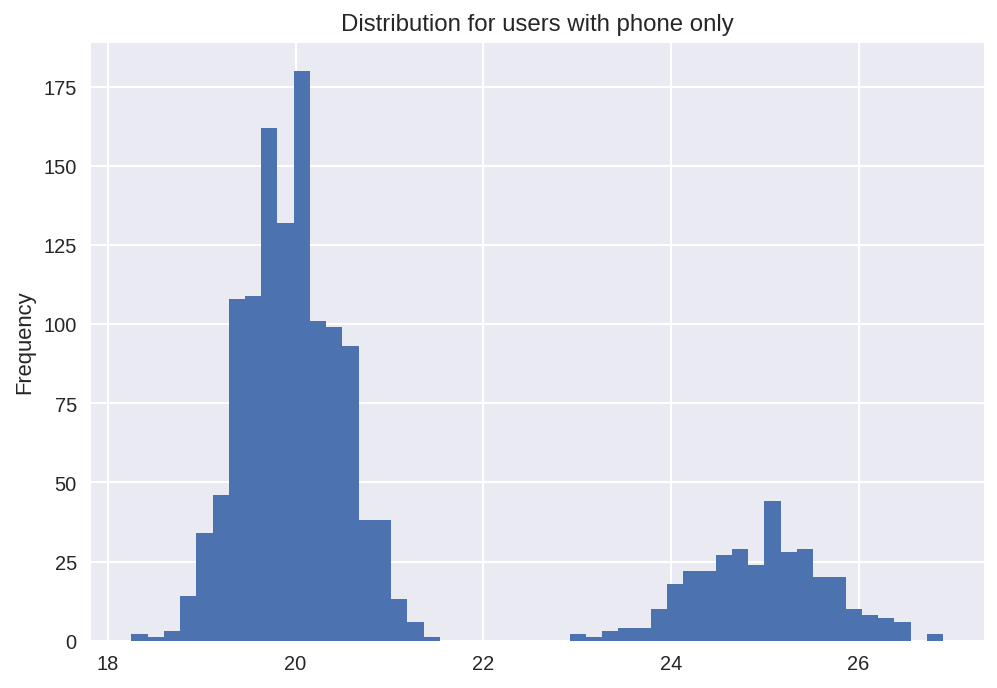

In [29]:
# create new dataset for users without internet, with phone only
df_with_phone_only = df_concated[df_concated['InternetService'] == 'No internet']

# plot the hist
df_with_phone_only['MonthlyCharges'].plot(kind='hist',
                                          bins=50,
                                          title='Distribution for users with phone only');

We see 2 distributions. I think one of them with `MultipleLines` = 1 ('Yes'), the other with `MultipleLines` = 0 ('No').

*Look at clients with phone only, with `MultipleLines` and without*

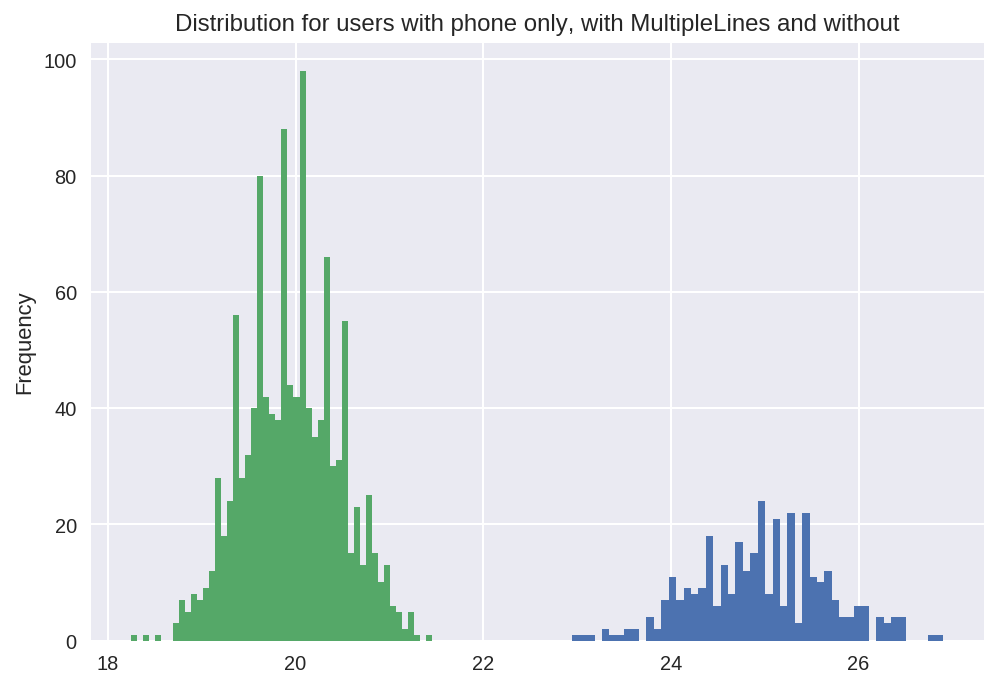

In [30]:
# create new dataset for users with phone only and with MultipleLines
df_with_phone_only_mult = df_with_phone_only[df_with_phone_only['MultipleLines'] == 'Yes']

# create new dataset for users with phone only and without MultipleLines
df_with_phone_only_nomult = df_with_phone_only[df_with_phone_only['MultipleLines'] == 'No']

# plot the hist
df_with_phone_only_mult['MonthlyCharges'].plot(kind='hist',
                                          bins=50,
                                          title='Distribution for users with phone only, with MultipleLines and without')
# plot the hist
df_with_phone_only_nomult['MonthlyCharges'].plot(kind='hist',
                                          bins=50);

We have 2 groups here.

*Look at clients with internet, with and without phone*

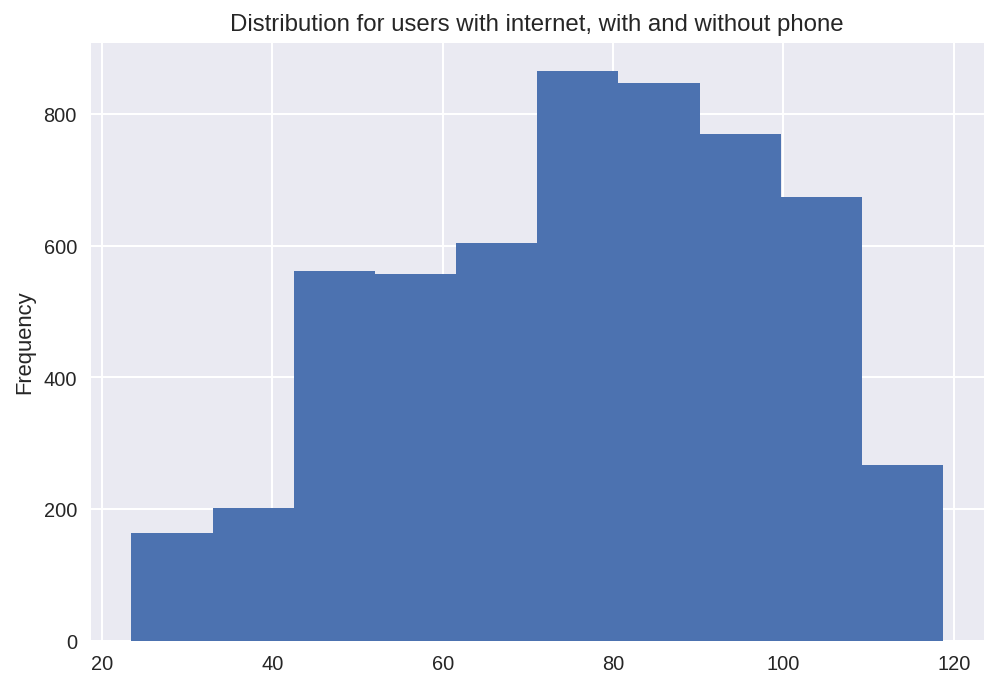

In [31]:
# create new dataset for users with internet, with and without phone
df_with_inter = df_concated[df_concated['InternetService'] != 'No internet']

# plot the hist
df_with_inter['MonthlyCharges'].plot(kind='hist',
                                     title='Distribution for users with internet, with and without phone');

*Look at clients with internet, with phone and with MultipleLines*

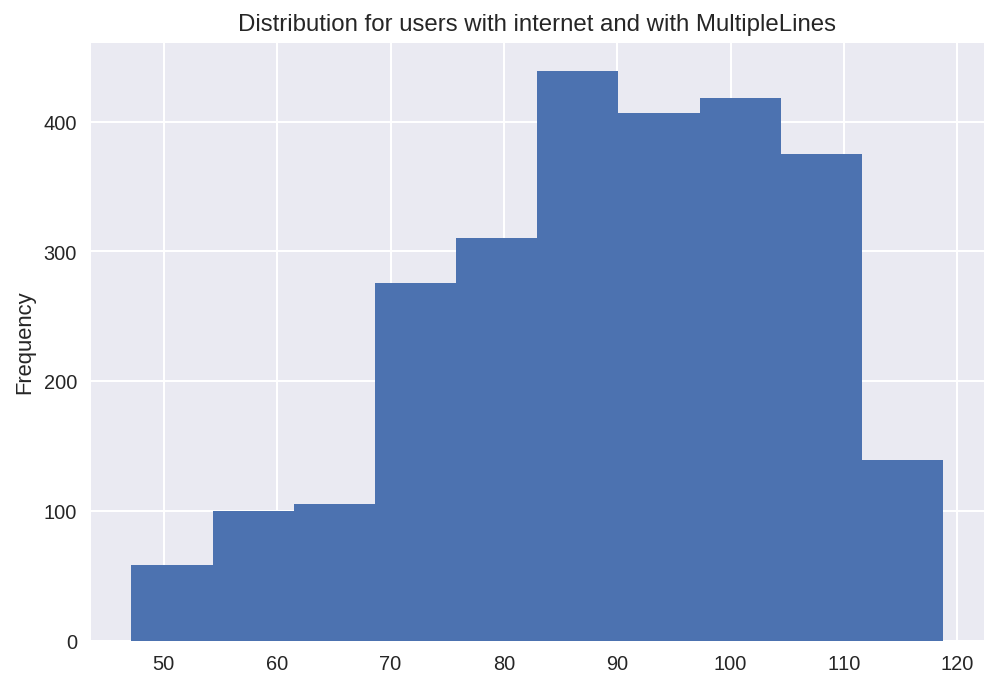

In [32]:
# create new dataset for users with internet and without phone
df_with_inter_mult = df_with_inter[df_with_inter['MultipleLines'] == 'Yes']

# plot the hist
df_with_inter_mult['MonthlyCharges'].plot(kind='hist',
                                          title='Distribution for users with internet and with MultipleLines');

*Look at clients with internet, with phone and without MultipleLines*

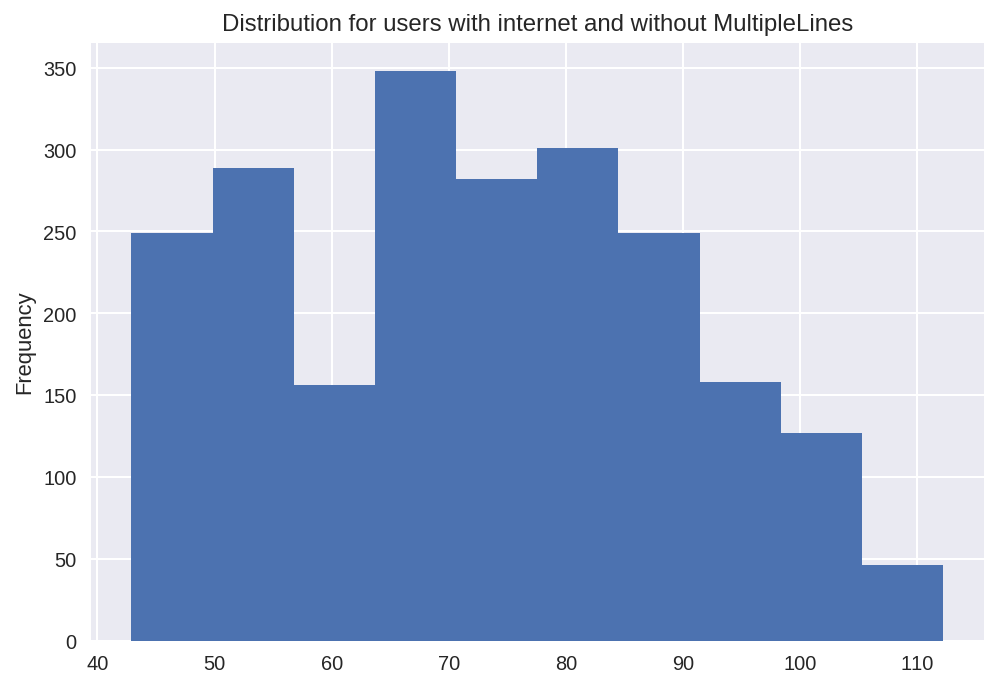

In [33]:
# create new dataset for users with internet and without phone
df_with_inter_nomult = df_with_inter[df_with_inter['MultipleLines'] == 'No']

# plot the hist
df_with_inter_nomult['MonthlyCharges'].plot(kind='hist',
                                            title='Distribution for users with internet and without MultipleLines');

*Look at clients with internet and without phone*

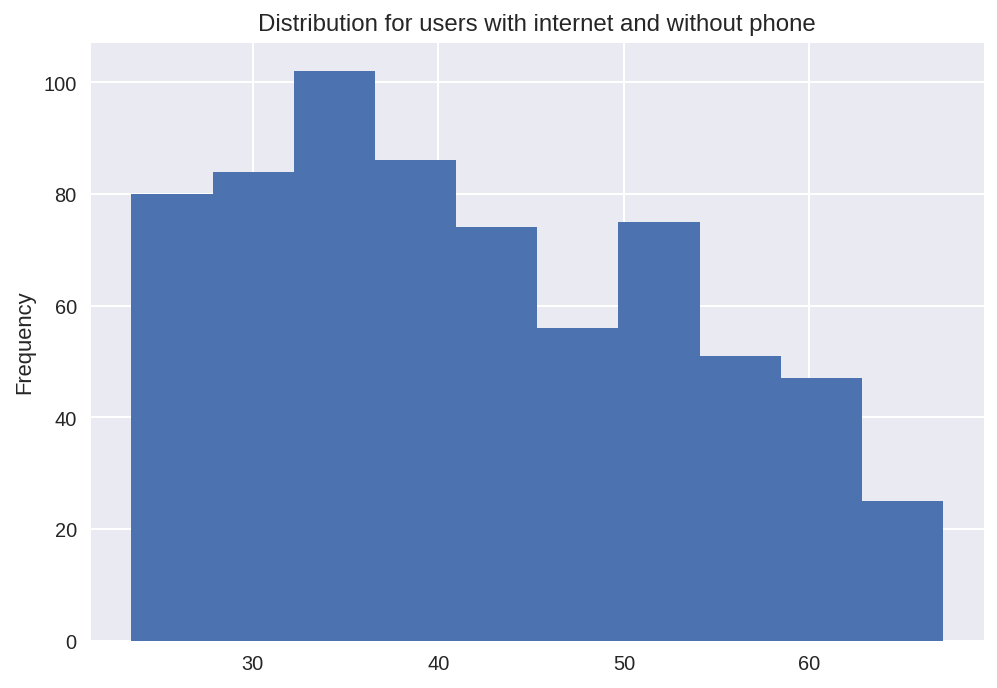

In [34]:
# create new dataset for users with internet and without phone
df_with_inter_nophone = df_with_inter[df_with_inter['MultipleLines'] == 'No phone']

# plot the hist
df_with_inter_nophone['MonthlyCharges'].plot(kind='hist',
                                             title='Distribution for users with internet and without phone');

These distributions are smoother.

*Let's look at `BeginDate` and `EndDate` columns*

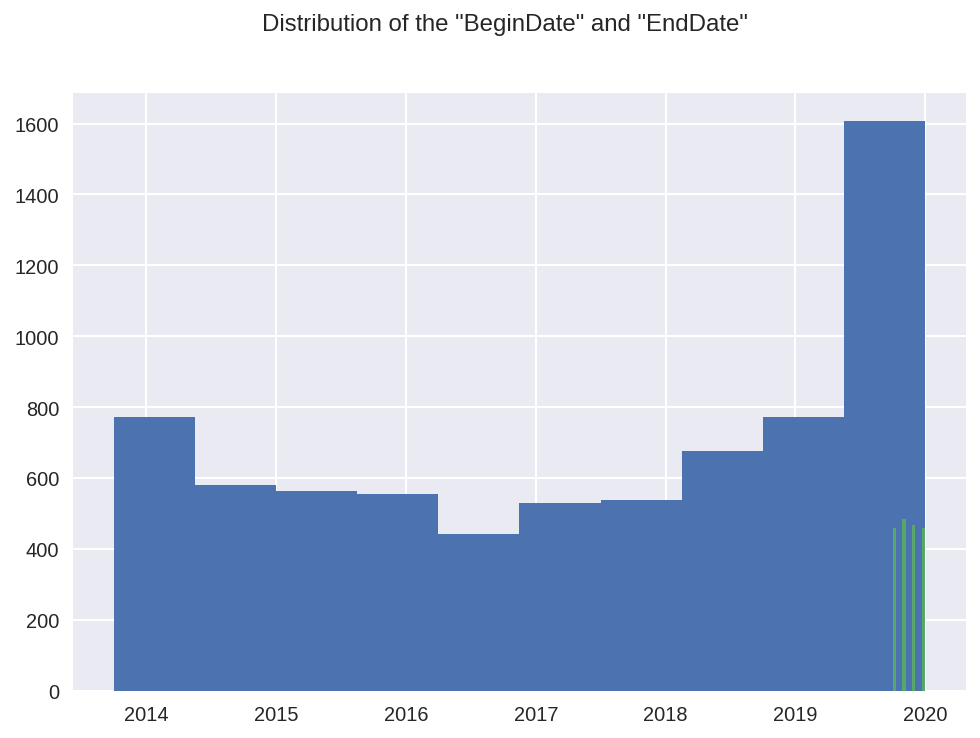

In [35]:
# use hist method for 'BeginDate' and 'EndDate'
df_concated['BeginDate'].hist()
df_concated['EndDate'].hist()
plt.suptitle('Distribution of the "BeginDate" and "EndDate"');

- We have the data for 6 years from 2014 to 2020.
- People started leaving in 2019.

*Let's calculate customer lifecycle values*

In [36]:
# add new column for 'EndDate'
df_concated['EndDate_new'] = df_concated['EndDate'].fillna('2020-02-01 00:00:00')

# convert to datetime format
df_concated['EndDate_new'] = pd.to_datetime(df_concated['EndDate_new'])

# calculate difference between 'BeginDate' and 'EndDate_new' columns in days
df_concated['Customer_lifecycle_days'] = (df_concated['EndDate_new'] - df_concated['BeginDate']).dt.days

*Check the values*

In [37]:
df_concated.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,EndDate_new,Customer_lifecycle_days
0,2020-01-01,NaT,Month-to-month,1,Electronic check,29.85,29.85,Female,0,1,0,DSL,0,1,0,0,0,0,No phone,2020-02-01,31
1,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,Male,0,0,0,DSL,1,0,1,0,0,0,No,2020-02-01,1036
2,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,Male,0,0,0,DSL,1,1,0,0,0,0,No,2019-12-01,61
3,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,Male,0,0,0,DSL,1,0,1,1,0,0,No phone,2020-02-01,1371
4,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,Female,0,0,0,Fiber optic,0,0,0,0,0,0,No,2019-11-01,61


*Plot the histogram for `Customer_lifecycle_days` column*

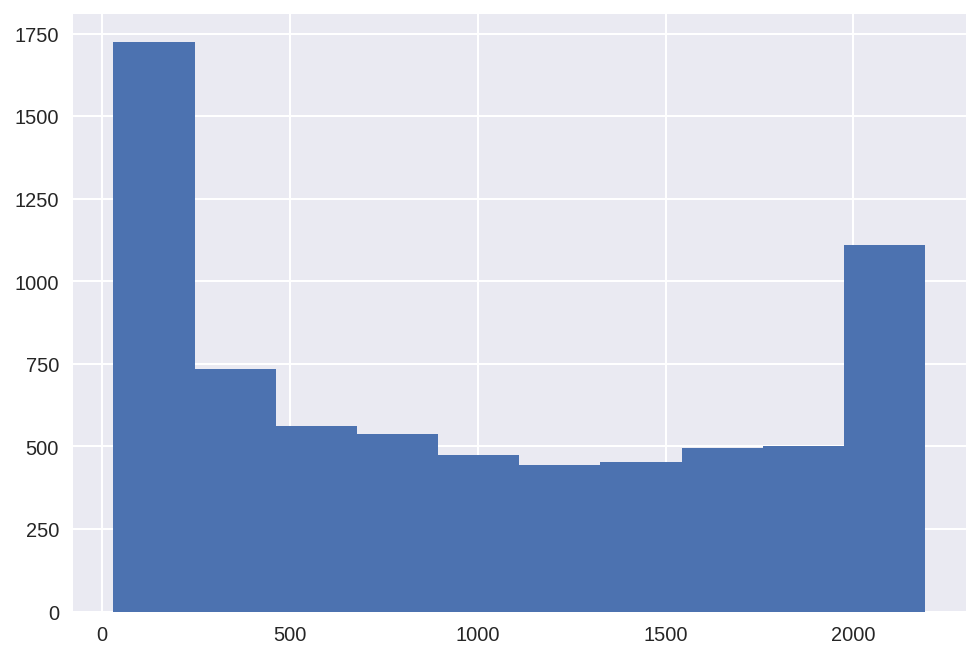

In [38]:
df_concated['Customer_lifecycle_days'].hist();

In [39]:
# use describe method for more information
df_concated['Customer_lifecycle_days'].describe()

count    7032.000000
mean      987.538538
std       747.153663
min        30.000000
25%       275.000000
50%       883.000000
75%      1676.000000
max      2191.000000
Name: Customer_lifecycle_days, dtype: float64

- The minimal customer_lifecycle is 1 month.
- The median is about 2.5 years.

*Let's look at `Type`, `PaymentMethod`, `gender`, `InternetService`, `MultipleLines` columns with 'plot.pie' method*

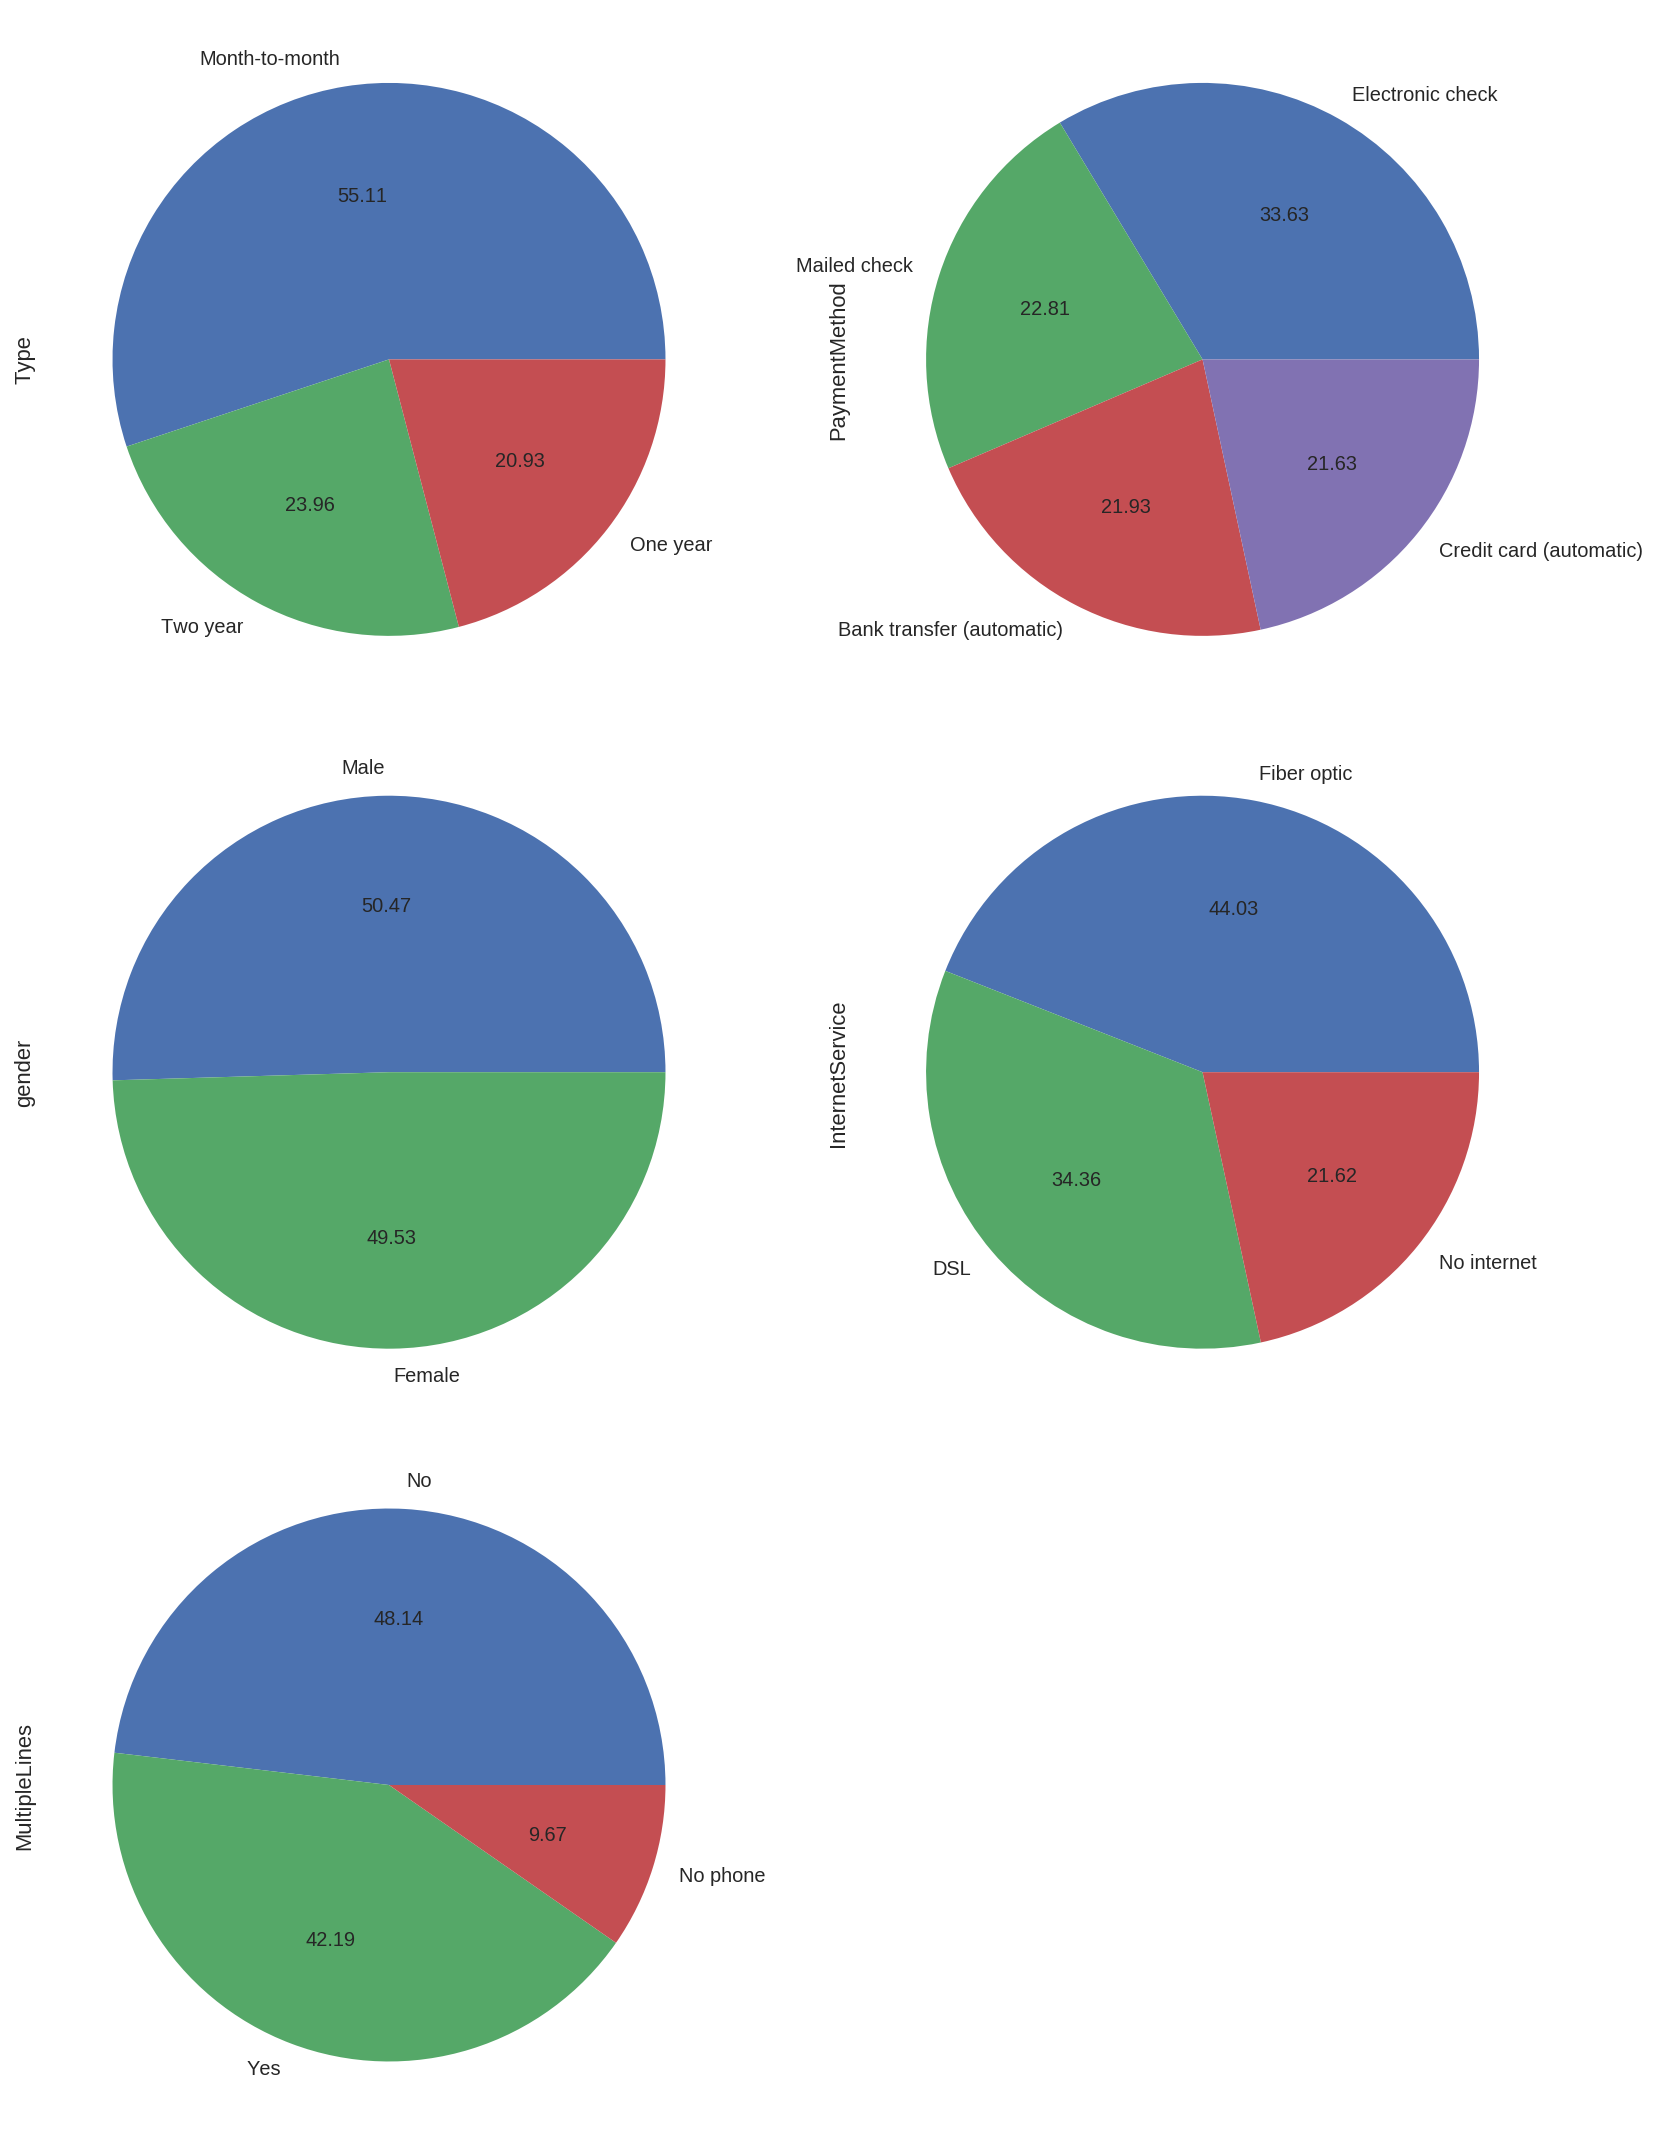

In [40]:
# plot the pie plots
f, axes = plt.subplots(3, 2, figsize=(12, 15))
f.delaxes(axes[2,1])
df_concated['Type'].value_counts().plot.pie(autopct='%.2f', ax=axes[0, 0])
df_concated['PaymentMethod'].value_counts().plot.pie(autopct='%.2f', ax=axes[0, 1])
df_concated['gender'].value_counts().plot.pie(autopct='%.2f', ax=axes[1, 0])
df_concated['InternetService'].value_counts().plot.pie(autopct='%.2f', ax=axes[1, 1])
df_concated['MultipleLines'].value_counts().plot.pie(autopct='%.2f', ax=axes[2, 0])
f.tight_layout();

- 55 % of users use monthly payment.
- Most people use fiber optic internet.
- About 21 % of users Interconnect company don't use the internet (only phone).
- About 9 % of people don't use the phone.

*Create new column with target for machine learning*

In [42]:
df_concated['Exited'] = (~df_concated['EndDate'].isna()).astype('int')

*Check the values*

In [43]:
df_concated.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,EndDate_new,Customer_lifecycle_days,Exited
0,2020-01-01,NaT,Month-to-month,1,Electronic check,29.85,29.85,Female,0,1,0,DSL,0,1,0,0,0,0,No phone,2020-02-01,31,0
1,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,Male,0,0,0,DSL,1,0,1,0,0,0,No,2020-02-01,1036,0
2,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,Male,0,0,0,DSL,1,1,0,0,0,0,No,2019-12-01,61,1
3,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,Male,0,0,0,DSL,1,0,1,1,0,0,No phone,2020-02-01,1371,0
4,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,Female,0,0,0,Fiber optic,0,0,0,0,0,0,No,2019-11-01,61,1


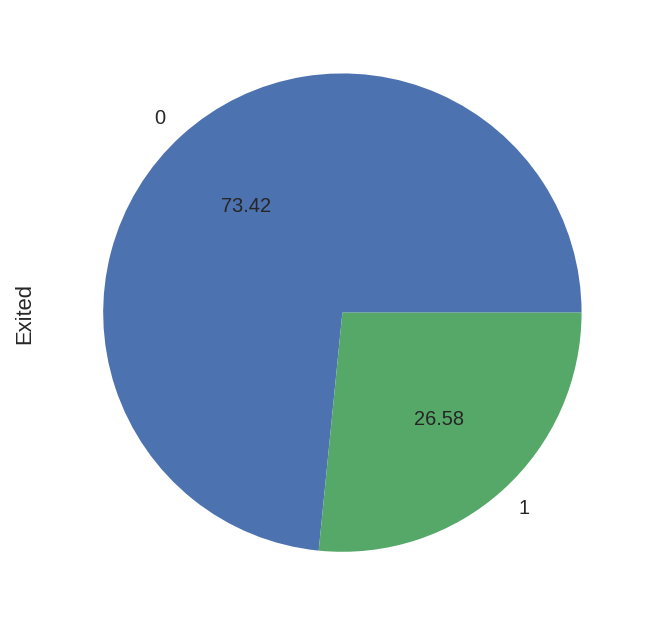

In [44]:
df_concated['Exited'].value_counts().plot.pie(autopct='%.2f');

About 27 % of clients left the company.

## 5. Machine learning (ML) <a name="ml"></a>

- Before machine learning we need to make OHE (One-Hot Encoding), because we have the categorical features and the models usually doesn't work with them.  
- Then we'll make unsampling. We have the imbalance between our classes. It affects learning.
- We'll try to train `DecisionTreeClassifier`, `RandomForestClassifier`, `LogisticRegression`, `CatBoostClassifier`, `XGBClassifier`, `LGBMClassifier` models. And then we'll compare results. 

### 5.1. Feature and target preparation <a name="feature_preparation"></a>

#### 5.1.1. OHE <a name="ohe"></a>

*Remove unnecessary for ML columns*

In [45]:
df_concated.drop(columns=['BeginDate', 'EndDate',
                          'EndDate_new'], inplace=True) # drop columns with 'drop()' method

df_concated.head() # check the result with 'head()' method

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Customer_lifecycle_days,Exited
0,Month-to-month,1,Electronic check,29.85,29.85,Female,0,1,0,DSL,0,1,0,0,0,0,No phone,31,0
1,One year,0,Mailed check,56.95,1889.50,Male,0,0,0,DSL,1,0,1,0,0,0,No,1036,0
2,Month-to-month,1,Mailed check,53.85,108.15,Male,0,0,0,DSL,1,1,0,0,0,0,No,61,1
3,One year,0,Bank transfer (automatic),42.30,1840.75,Male,0,0,0,DSL,1,0,1,1,0,0,No phone,1371,0
4,Month-to-month,1,Electronic check,70.70,151.65,Female,0,0,0,Fiber optic,0,0,0,0,0,0,No,61,1


*Make One-Hot Encoding of categorical features with "drop_first" parameter for `Type`, `PaymentMethod`, `InternetService`, `MultipleLines`,`gender` columns*

In [46]:
# use 'get_dummies()' method
df_concated_ohe = pd.get_dummies(df_concated, columns=['Type', 'PaymentMethod',
                                                   'InternetService', 'MultipleLines', 'gender'],
                                 drop_first=True)

*Check the results*

In [47]:
df_concated_ohe.head()

,PaperlessBilling,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Customer_lifecycle_days,Exited,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No internet,MultipleLines_No phone,MultipleLines_Yes,gender_Male
0,1,29.85,29.85,0,1,0,0,1,0,0,0,0,31,0,0,0,0,1,0,0,0,1,0,0
1,0,56.95,1889.50,0,0,0,1,0,1,0,0,0,1036,0,1,0,0,0,1,0,0,0,0,1
2,1,53.85,108.15,0,0,0,1,1,0,0,0,0,61,1,0,0,0,0,1,0,0,0,0,1
3,0,42.30,1840.75,0,0,0,1,0,1,1,0,0,1371,0,1,0,0,0,0,0,0,1,0,1
4,1,70.70,151.65,0,0,0,0,0,0,0,0,0,61,1,0,0,0,1,0,1,0,0,0,0


All features're numerical now.

#### 5.1.2. Feature and target creation <a name="feature_creation"></a>

In [48]:
# create features and target datasets
X = df_concated_ohe.drop(['Exited'], axis=1)
y = df_concated_ohe['Exited']

In [49]:
# split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42)

In [50]:
# look at the features
X_train.head()

,PaperlessBilling,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Customer_lifecycle_days,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No internet,MultipleLines_No phone,MultipleLines_Yes,gender_Male
3166,0,48.80,664.40,0,1,0,0,0,0,1,0,0,427,0,0,0,0,0,0,0,0,0,1
4333,1,90.55,2929.75,0,1,0,1,1,0,1,0,0,945,0,0,1,0,0,1,0,0,1,1
1927,1,107.35,5118.95,0,1,1,0,0,1,1,1,1,1430,0,0,0,0,0,1,0,0,1,1
2315,1,73.45,2661.10,0,1,1,0,0,0,1,1,1,1067,1,0,0,0,0,0,0,0,1,1
858,0,89.00,5898.60,0,1,0,1,1,0,1,0,0,2010,1,0,0,1,0,1,0,0,1,0


In [52]:
# # scale the data
# scaler = MinMaxScaler(feature_range = (0,1))
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

### 5.2. Model Training <a name="model_training"></a>

- We'll try to tune models with different hyperparameters with 'GridSearchCV' from Scikit-learn.
- We'll fix the imbalanced classes using the 'imblearn pipeline' and 'SMOTE' function.
- We'll make feature scaling with 'MinMaxScaler()' inside of pipeline.

*Create a dictionaries with model params for `DecisionTreeClassifier`, `RandomForestClassifier`, `LogisticRegression`, `CatBoostClassifier`, `XGBClassifier`, `LGBMClassifier`*

In [51]:
# create a dictionary with model params for DecisionTreeClassifier
dt_params = {
    'DecisionTreeClassifier': {
        'model': make_pipeline(SMOTE(random_state=42), MinMaxScaler(feature_range = (0,1)),
                               DecisionTreeClassifier(random_state=12345)),
        'params' : {
            'decisiontreeclassifier__max_depth': range(1, 10),
            'decisiontreeclassifier__min_samples_split': range(2, 40, 10), 
            'decisiontreeclassifier__min_samples_leaf': range(1, 20, 5)
        }  
    }
}

# create a dictionary with model params for RandomForestClassifier
rf_params = {
    'RandomForestClassifier': {
        'model': make_pipeline(SMOTE(random_state=42), MinMaxScaler(feature_range = (0,1)),
                               RandomForestClassifier(random_state=12345)),
        'params' : {
            'randomforestclassifier__n_estimators': range(10, 200, 20)
        }
    } 
}

# create a dictionary with model params for LogisticRegression
logreg_params = {
    'LogisticRegression' : {
        'model': make_pipeline(SMOTE(random_state=42), MinMaxScaler(feature_range = (0,1)), 
                               LogisticRegression(solver='liblinear', random_state=12345)),
        'params' : {
            'logisticregression__C': [1,5,10]
        }
    }
}

# create a dictionary with model params for Catboost
cat_params = {
    'CatBoostClassifier' : {
        'model': make_pipeline(SMOTE(random_state=42), MinMaxScaler(feature_range = (0,1)), 
                               CatBoostClassifier(loss_function='Logloss',
                                                  iterations=200,random_state=12345)),
        'params' : {
            'catboostclassifier__learning_rate': [.2, .4, .5],
            'catboostclassifier__depth': range(1, 10)
        }
    }
}

# create a dictionary with model params for XGBClassifier
xgb_params = {
    'XGBClassifier' : {
        'model': make_pipeline(SMOTE(random_state=42), MinMaxScaler(feature_range = (0,1)), 
                               XGBClassifier(random_state=12345)),
        'params' : {
            'xgbclassifier__eta': [.2, .4, .5],
            'xgbclassifier__max_depth': range(1, 10)
        }
    }
}

# create a dictionary with model params for LightGBM
lgbm_params = {
    'LGBMClassifier' : {
        'model': make_pipeline(SMOTE(random_state=42), MinMaxScaler(feature_range = (0,1)), 
                               LGBMClassifier(random_state=12345)),
        'params' : {
            'lgbmclassifier__num_leaves ': [10, 20, 30],
            'lgbmclassifier__max_depth': range(1, 10)
        }
    }
}

*Create the function for cross-validation scoring with GridSearchCV*

In [52]:
def best_train_score(model_params):

    for model_name, mp in model_params.items():

        # create classifier with 'GridSearchCV()'
        clf =  GridSearchCV(mp['model'], mp['params'], cv=5,
                                  return_train_score=False, scoring='roc_auc')
        # fit the model
        clf.fit(X_train, y_train)
        
        # print the scores and best model parameters
        print('model:', model_name)
        print()
        print('best_roc_auc:', clf.best_score_)
        print()
        print('best_params:', clf.best_params_)
        print()
    
    return clf

*Create the function for test dataset scoring*

In [53]:
def test_scores(model):
    
    # predict the values
    predicted_test = model.predict(X_test) 

    # predict probabilities
    probabilities_test = model.predict_proba(X_test)
    probabilities_one_test = probabilities_test[:, 1]

    # calculate auc_roc
    auc_roc = roc_auc_score(y_test, probabilities_one_test)

    # calculate accuracy
    accuracy = accuracy_score(y_test, predicted_test)

    # calculate f1_score
    f1_test = f1_score(y_test, predicted_test) # count the test score

    # print the scores
    print('auc_roc:', auc_roc)
    print('accuracy:', accuracy)
    print('f1_score:', f1_test)
    
    
    # plot the roc curve
    fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)

    plt.figure()

    # plot the graph
    plt.plot(fpr, tpr)

    # ROC curve for random model (looks like a straight line)
    plt.plot([0, 1], [0, 1], linestyle='--')

    # use the functions plt.xlim() and plt.ylim() to
    # set the boundary for the axes from 0 to 1
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])

    # use the functions plt.xlabel() and plt.ylabel() to
    # name the axes "False Positive Rate" and "True Positive Rate" 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    # add the heading "ROC curve" with the function plt.title()
    plt.title('ROC curve');
    
    return predicted_test

#### 5.2.1. DecisionTreeClassifier <a name="dt"></a>

In [54]:
%%time
# calculate 'roc_auc' for train dataset
dt_model = best_train_score(dt_params)

model: DecisionTreeClassifier

best_roc_auc: 0.8242023729461108

best_params: {'decisiontreeclassifier__max_depth': 6, 'decisiontreeclassifier__min_samples_leaf': 6, 'decisiontreeclassifier__min_samples_split': 32}

CPU times: user 44.5 s, sys: 174 ms, total: 44.6 s
Wall time: 45.1 s


auc_roc: 0.8047623446422572
accuracy: 0.7662116040955631
f1_score: 0.591044776119403


array([0, 0, 1, ..., 0, 1, 0])

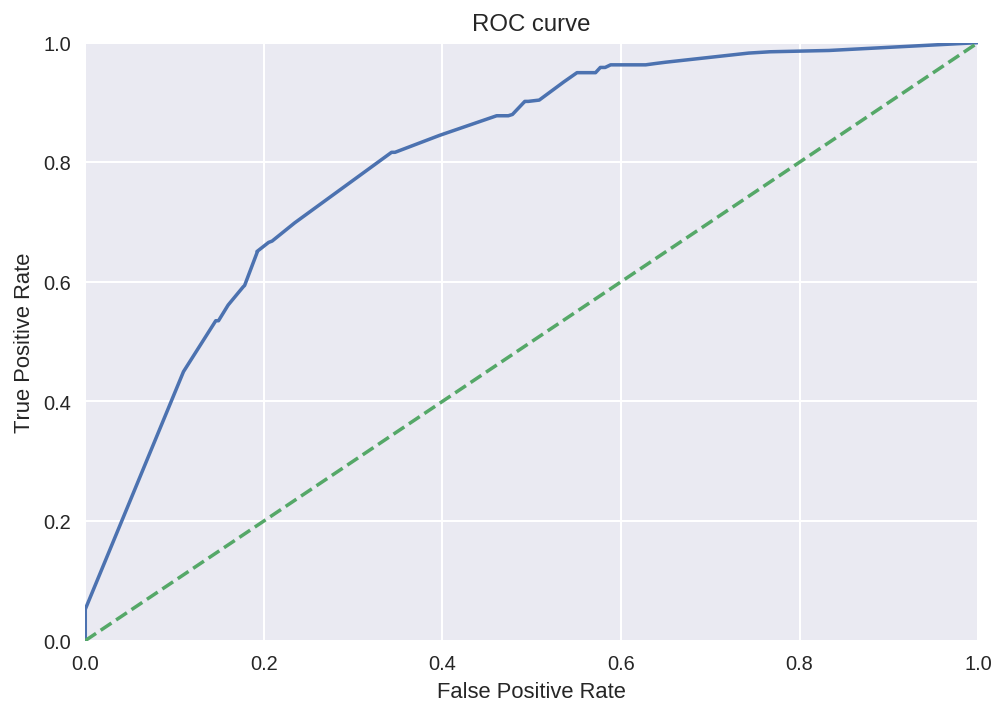

In [55]:
# calculate 'roc_auc' for test dataset
test_scores(dt_model)

#### 5.2.2. RandomForestClassifier <a name="rd"></a>

In [56]:
%%time
# calculate 'roc_auc' for train dataset
rf_model = best_train_score(rf_params)

model: RandomForestClassifier

best_roc_auc: 0.8417378937302497

best_params: {'randomforestclassifier__n_estimators': 190}

CPU times: user 50.7 s, sys: 129 ms, total: 50.8 s
Wall time: 51.3 s


auc_roc: 0.8191039637218676
accuracy: 0.7741751990898749
f1_score: 0.5744908896034299


array([0, 0, 1, ..., 0, 0, 0])

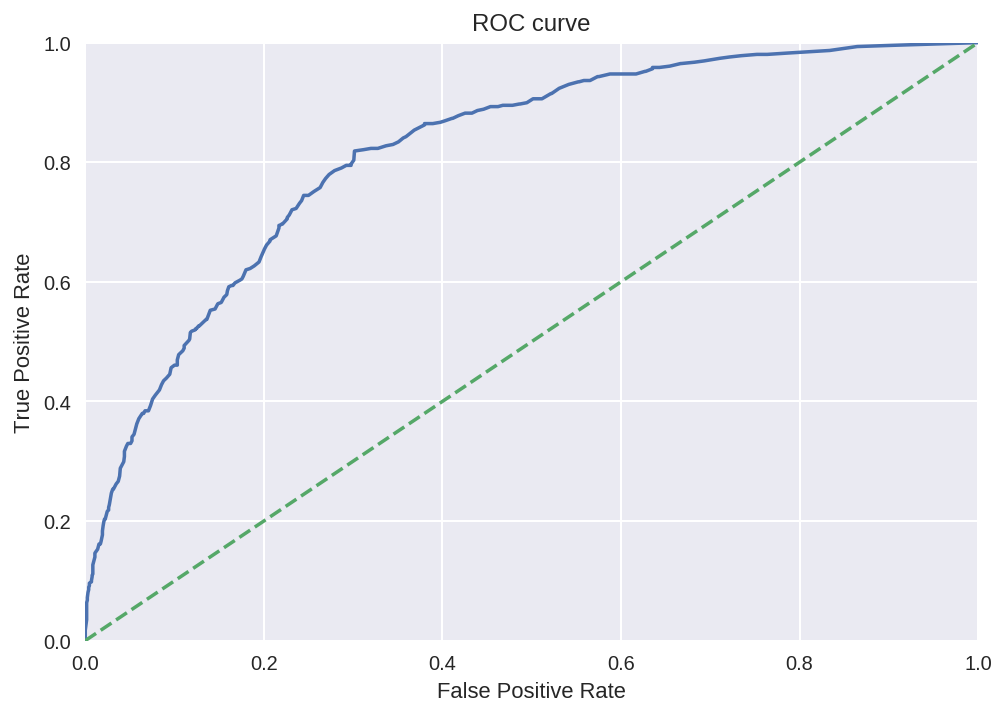

In [57]:
# calculate 'roc_auc' for test dataset
test_scores(rf_model)

#### 5.2.3. LogisticRegression <a name="logreg"></a>

In [58]:
%%time
# calculate 'roc_auc' for train dataset
logreg_model = best_train_score(logreg_params)

model: LogisticRegression

best_roc_auc: 0.8259863273614668

best_params: {'logisticregression__C': 5}

CPU times: user 2.77 s, sys: 1.13 s, total: 3.9 s
Wall time: 3.91 s


auc_roc: 0.8075915351024521
accuracy: 0.7610921501706485
f1_score: 0.5969289827255279


array([0, 0, 1, ..., 0, 1, 0])

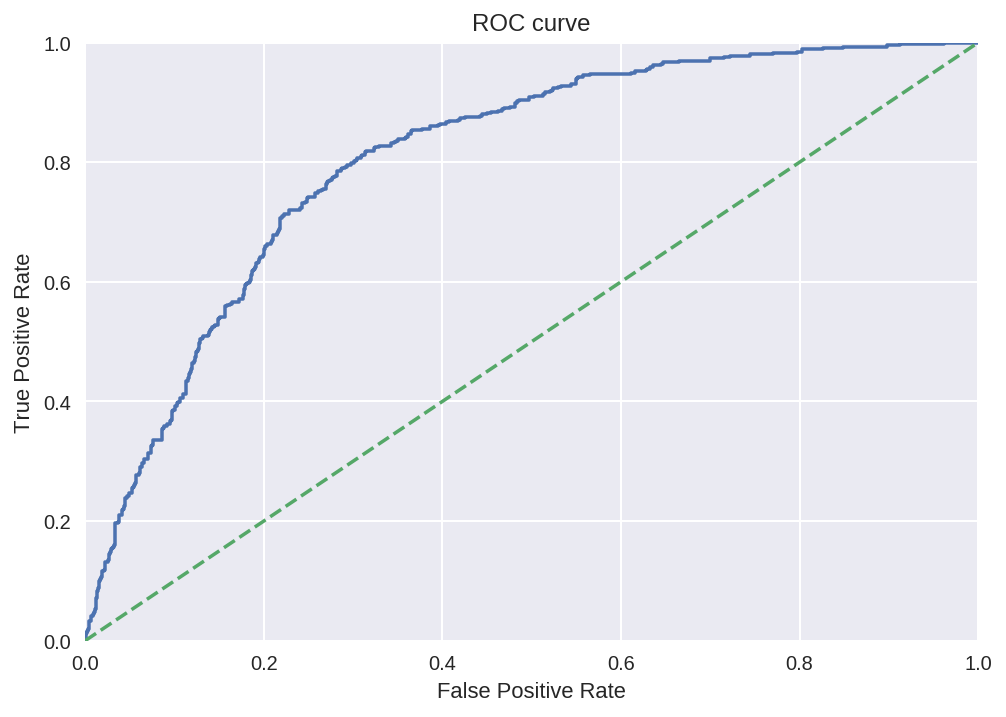

In [59]:
# calculate 'roc_auc' for test dataset
test_scores(logreg_model)

#### 5.2.4. CatBoostClassifier <a name="cat"></a>

In [60]:
%%time
# calculate 'roc_auc' for train dataset
cat_model = best_train_score(cat_params)

0:	learn: 0.6484833	total: 51.6ms	remaining: 10.3s
1:	learn: 0.6269683	total: 54.8ms	remaining: 5.43s
2:	learn: 0.6078709	total: 57.2ms	remaining: 3.75s
3:	learn: 0.5884454	total: 59.8ms	remaining: 2.93s
4:	learn: 0.5750086	total: 63.6ms	remaining: 2.48s
5:	learn: 0.5635854	total: 67.8ms	remaining: 2.19s
6:	learn: 0.5514780	total: 71.8ms	remaining: 1.98s
7:	learn: 0.5388906	total: 76.1ms	remaining: 1.82s
8:	learn: 0.5243507	total: 80.3ms	remaining: 1.7s
9:	learn: 0.5145254	total: 84.2ms	remaining: 1.6s
10:	learn: 0.5092128	total: 159ms	remaining: 2.73s
11:	learn: 0.5001518	total: 162ms	remaining: 2.54s
12:	learn: 0.4934994	total: 167ms	remaining: 2.4s
13:	learn: 0.4874297	total: 171ms	remaining: 2.27s
14:	learn: 0.4819515	total: 175ms	remaining: 2.16s
15:	learn: 0.4687313	total: 179ms	remaining: 2.06s
16:	learn: 0.4647219	total: 182ms	remaining: 1.96s
17:	learn: 0.4600774	total: 256ms	remaining: 2.59s
18:	learn: 0.4563606	total: 261ms	remaining: 2.49s
19:	learn: 0.4524745	total: 265ms	

auc_roc: 0.8997304333221363
accuracy: 0.8492605233219568
f1_score: 0.7135135135135134


array([0., 0., 1., ..., 1., 0., 0.])

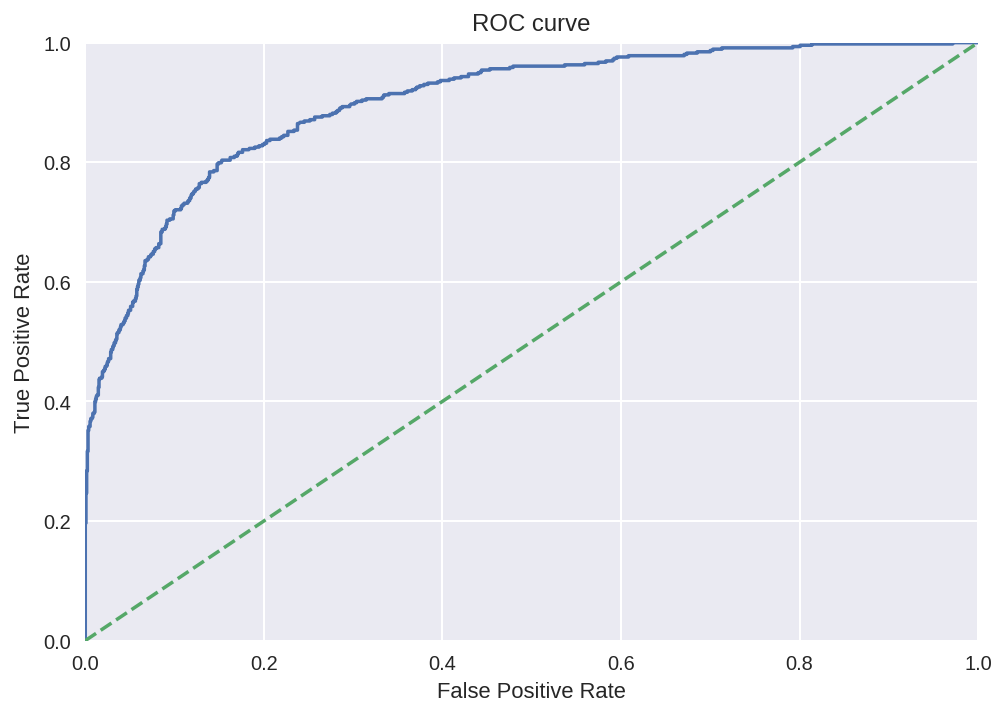

In [61]:
# calculate 'roc_auc' for test dataset
test_scores(cat_model)

#### 5.2.5. XGBClassifier <a name="xgb"></a>

In [62]:
%%time
# calculate 'roc_auc' for train dataset
xgb_model = best_train_score(xgb_params)

model: XGBClassifier

best_roc_auc: 0.872232927170846

best_params: {'xgbclassifier__eta': 0.2, 'xgbclassifier__max_depth': 6}

CPU times: user 2min 31s, sys: 0 ns, total: 2min 31s
Wall time: 2min 32s


auc_roc: 0.8518357406785355
accuracy: 0.78839590443686
f1_score: 0.6133056133056134


array([0, 0, 1, ..., 0, 0, 0])

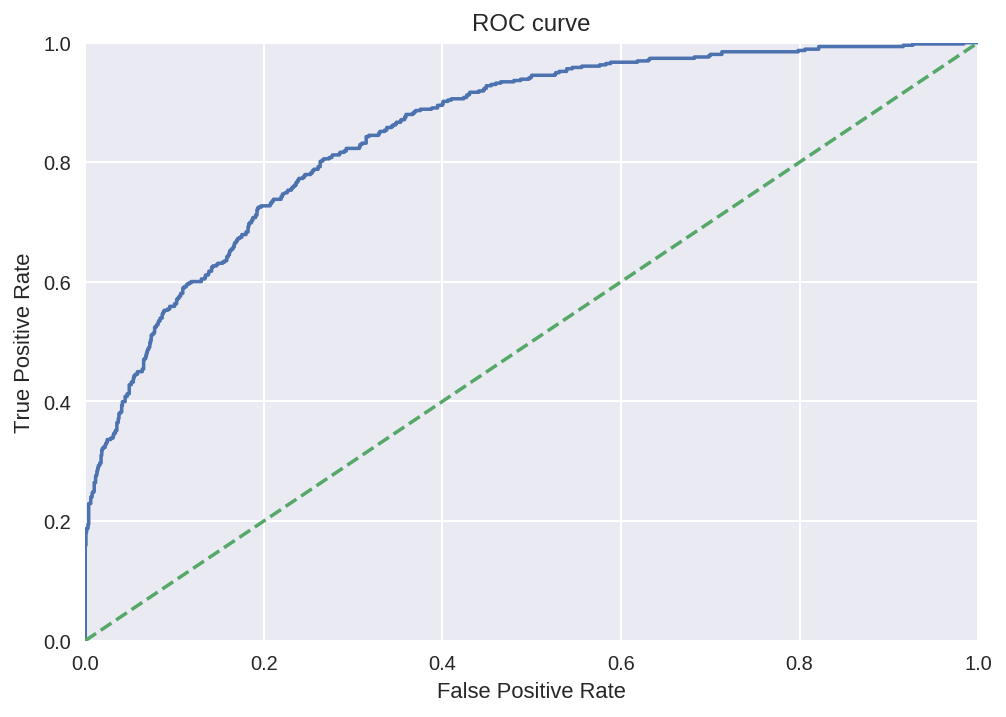

In [63]:
# calculate 'roc_auc' for test dataset
test_scores(xgb_model)

#### 5.2.6. LightGBM <a name="lgbm"></a>

In [64]:
%%time
# calculate 'roc_auc' for train dataset
lgbm_model = best_train_score(lgbm_params)

model: LGBMClassifier

best_roc_auc: 0.8744059698359437

best_params: {'lgbmclassifier__max_depth': 8, 'lgbmclassifier__num_leaves ': 10}

CPU times: user 31.3 s, sys: 0 ns, total: 31.3 s
Wall time: 31.3 s


auc_roc: 0.8537092710782667
accuracy: 0.7992036405005688
f1_score: 0.6272439281942978


array([0, 0, 1, ..., 0, 0, 0])

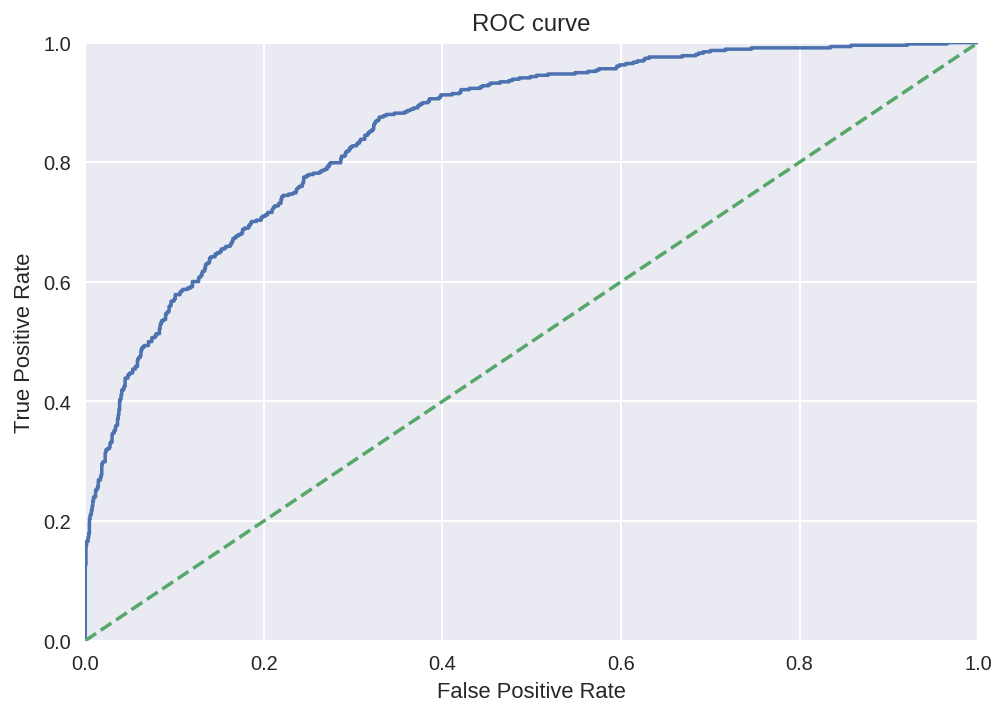

In [65]:
# calculate 'roc_auc' for test dataset
test_scores(lgbm_model)

### 5.3. The best model choosing <a name="the_best_model"></a>

Catboost model gives the best 'roc_auc' metric = 0.8997 and 'accuracy' = 0.8493 on the test dataset. 

## 6. Overall conclusion <a name="overall_concl"></a>

Catboost is the best model with these hyperparameters:
- {loss_function='Logloss', iterations=200, 'depth': 3, 'learning_rate': 0.5}.